In [176]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import warnings as warn 

from plotly import express as px 
from fuzzywuzzy import fuzz 
from tqdm import tqdm 
from matplotlib import pyplot as plt 
from yellowbrick.features.pca import PCADecomposition
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, mutual_info_classif 
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from statsmodels.graphics.mosaicplot import mosaic 
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split 
from sklearn import set_config 

set_config(display = "diagram")
warn.simplefilter("ignore")

# Data Preperation and Collection 

In [183]:
evs = pd.read_csv("DATA/Electric_Vehicle_Population_Data.csv")
cars = pd.read_csv("DATA/ElectricCarData_Clean.csv")

display(evs)

VIN (1-10)     County           City State  Postal Code  Model Year  \
0       JTMEB3FV6N     Monroe       Key West    FL        33040        2022   
1       1G1RD6E45D      Clark       Laughlin    NV        89029        2013   
2       JN1AZ0CP8B     Yakima         Yakima    WA        98901        2011   
3       1G1FW6S08H     Skagit       Concrete    WA        98237        2017   
4       3FA6P0SU1K  Snohomish        Everett    WA        98201        2019   
...            ...        ...            ...   ...          ...         ...   
112629  7SAYGDEF2N       King         Duvall    WA        98019        2022   
112630  1N4BZ1CP7K   San Juan  Friday Harbor    WA        98250        2019   
112631  1FMCU0KZ4N       King         Vashon    WA        98070        2022   
112632  KNDCD3LD4J       King      Covington    WA        98042        2018   
112633  YV4BR0CL8N       King      Covington    WA        98042        2022   

             Make       Model                   Electric Vehicle Type  \
0          TOYOTA  RAV4 PRIME  Plug-in Hybrid Electric Vehicle (PHEV)   
1       CHEVROLET        VOLT  Plug-in Hybrid Electric Vehicle (PHEV)   
2          NISSAN        LEAF          Battery Electric Vehicle (BEV)   
3       CHEVROLET     BOLT EV          Battery Electric Vehicle (BEV)   
4            FORD      FUSION  Plug-in Hybrid Electric Vehicle (PHEV)   
...           ...         ...                                     ...   
112629      TESLA     MODEL Y          Battery Electric Vehicle (BEV)   
112630     NISSAN        LEAF          Battery Electric Vehicle (BEV)   
112631       FORD      ESCAPE  Plug-in Hybrid Electric Vehicle (PHEV)   
112632        KIA        NIRO  Plug-in Hybrid Electric Vehicle (PHEV)   
112633      VOLVO        XC90  Plug-in Hybrid Electric Vehicle (PHEV)   

        Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0                 Clean Alternative Fuel Vehicle Eligible              42   
1                 Clean Alternative Fuel Vehicle Eligible              38   
2                 Clean Alternative Fuel Vehicle Eligible              73   
3                 Clean Alternative Fuel Vehicle Eligible             238   
4                   Not eligible due to low battery range              26   
...                                                   ...             ...   
112629  Eligibility unknown as battery range has not b...               0   
112630            Clean Alternative Fuel Vehicle Eligible             150   
112631            Clean Alternative Fuel Vehicle Eligible              38   
112632              Not eligible due to low battery range              26   
112633              Not eligible due to low battery range              18   

        Base MSRP  Legislative District  DOL Vehicle ID  \
0               0                   NaN       198968248   
1               0                   NaN         5204412   
2               0                  15.0       218972519   
3               0                  39.0       186750406   
4               0                  38.0         2006714   
...           ...                   ...             ...   
112629          0                  45.0       217955265   
112630          0                  40.0       103663227   
112631          0                  34.0       193878387   
112632          0                  47.0       125039043   
112633          0                  47.0       194673692   

                   Vehicle Location  \
0         POINT (-81.80023 24.5545)   
1       POINT (-114.57245 35.16815)   
2       POINT (-120.50721 46.60448)   
3        POINT (-121.7515 48.53892)   
4       POINT (-122.20596 47.97659)   
...                             ...   
112629  POINT (-121.98609 47.74068)   
112630  POINT (-123.01648 48.53448)   
112631   POINT (-122.4573 47.44929)   
112632  POINT (-122.09124 47.33778)   
112633  POINT (-122.09124 47.33778)   

                                         Electric Utility  2020 Census Tract  


In [184]:
evs.Make.unique()

array(['TOYOTA', 'CHEVROLET', 'NISSAN', 'FORD', 'TESLA', 'KIA', 'AUDI',
       'FIAT', 'BMW', 'PORSCHE', 'CADILLAC', 'HONDA', 'MITSUBISHI',
       'CHRYSLER', 'RIVIAN', 'HYUNDAI', 'VOLVO', 'VOLKSWAGEN',
       'MERCEDES-BENZ', 'JEEP', 'MINI', 'SMART', 'SUBARU', 'POLESTAR',
       'LUCID MOTORS', 'LINCOLN', 'JAGUAR', 'FISKER', 'LAND ROVER',
       'LEXUS', 'TH!NK', 'GENESIS', 'BENTLEY', 'AZURE DYNAMICS'],
      dtype=object)

In [185]:
in_car_maker = [car.upper().strip() for car in cars.Brand.unique()]
in_evs_maker = [evs_car for evs_car in evs.Make.unique()]

common_words = list(set(in_evs_maker).intersection(set(in_car_maker))) 
evs = evs.loc[evs.Make.isin(common_words)]

### Since the models are not named exactly the same we will partially match the model names

In [186]:
def pmatch(text, matches):
    best_score = 0 
    best_word = None 
    for match in matches: 
        fuzz_ratio = fuzz.partial_ratio(text, match)
        if fuzz_ratio > best_score: 
            best_score = fuzz_ratio 
            best_word = match 

    return best_word 

def generate_modelmap(): 
    in_car_model = list(cars.Model.unique()) 
    in_evs_model = [str(model).lower() for model in list(evs.Model.unique()) if not pd.isna(model)]
    
    model_map = {}

    for model_evs in tqdm(in_evs_model): 
        best_match = pmatch(model_evs, in_car_model)
        model_map[model_evs.upper()] = best_match 
        in_car_model.remove(best_match)

    return model_map 

model_map = generate_modelmap()
evs["Model"] = evs.Model.map(model_map)

100%|██████████| 73/73 [00:00<00:00, 659.86it/s]


In [187]:
evs = pd.merge(evs, cars, how = "inner", on = "Model").drop_duplicates().drop(columns=['VIN (1-10)', 'Postal Code', 'DOL Vehicle ID', 'Vehicle Location', '2020 Census Tract'])
display(evs.sample(10))

County      City State  Model Year        Make  \
28434     Benton  Richland    WA        2021       TESLA   
34930       King  Issaquah    WA        2018       TESLA   
80713     Pierce    Graham    WA        2022  VOLKSWAGEN   
9550    Thurston   Olympia    WA        2013      NISSAN   
58275       King   Seattle    WA        2017         BMW   
33293  Snohomish   Everett    WA        2020       TESLA   
40628       King  Issaquah    WA        2018       TESLA   
28752       King    Auburn    WA        2019       TESLA   
20237       King  Kirkland    WA        2018       TESLA   
62331       King   Redmond    WA        2021       TESLA   

                               Model           Electric Vehicle Type  \
28434  Model 3 Long Range Dual Motor  Battery Electric Vehicle (BEV)   
34930  Model 3 Long Range Dual Motor  Battery Electric Vehicle (BEV)   
80713                          ID.4   Battery Electric Vehicle (BEV)   
9550                           Leaf   Battery Electric Vehicle (BEV)   
58275                      i3 120 Ah  Battery Electric Vehicle (BEV)   
33293  Model 3 Long Range Dual Motor  Battery Electric Vehicle (BEV)   
40628    Model 3 Standard Range Plus  Battery Electric Vehicle (BEV)   
28752  Model 3 Long Range Dual Motor  Battery Electric Vehicle (BEV)   
20237  Model 3 Long Range Dual Motor  Battery Electric Vehicle (BEV)   
62331             Model S Long Range  Battery Electric Vehicle (BEV)   

       Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
28434  Eligibility unknown as battery range has not b...               0   
34930            Clean Alternative Fuel Vehicle Eligible             215   
80713  Eligibility unknown as battery range has not b...               0   
9550             Clean Alternative Fuel Vehicle Eligible              75   
58275            Clean Alternative Fuel Vehicle Eligible              81   
33293            Clean Alternative Fuel Vehicle Eligible             308   
40628            Clean Alternative Fuel Vehicle Eligible             238   
28752            Clean Alternative Fuel Vehicle Eligible             220   
20237            Clean Alternative Fuel Vehicle Eligible             215   
62331  Eligibility unknown as battery range has not b...               0   

       Base MSRP  ...  Range_Km Efficiency_WhKm FastCharge_KmH  RapidCharge  \
28434          0  ...       450             161            940          Yes   
34930          0  ...       450             161            940          Yes   
80713          0  ...       420             183            560          Yes   
9550           0  ...       220             164            230          Yes   
58275          0  ...       235             161            270          Yes   
33293          0  ...       450             161            940          Yes   
40628          0  ...       310             153            650          Yes   
28752          0  ...       450             161            940          Yes   
20237          0  ...       450             161            940          Yes   
62331          0  ...       515             184            560          Yes   

       PowerTrain        PlugType  BodyStyle Segment Seats PriceEuro  
28434         AWD      Type 2 CCS      Sedan       D     5     55480  
34930         AWD      Type 2 CCS      Sedan       D     5     55480  
80713         RWD      Type 2 CCS        SUV       C     5     45000  
9550          FWD  Type 2 CHAdeMO  Hatchback       C     5     29234  
58275         RWD      Type 2 CCS  Hatchback       B     4     38017  
33293         AWD      Type 2 CCS      Sedan       D     5     55480  
40628         RWD      Type 2 CCS      Sedan       D     5     46380  
28752         AWD      Type 2 CCS      Sedan       D     5     55480  
20237         AWD      Type 2 CCS      Sedan       D     5     55480  
62331         AWD          Type 2   Liftback       F     5     79990  

[10 rows x 25 columns]

### EDA process

In [7]:
evs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93042 entries, 0 to 93041
Data columns (total 25 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   County                                             93042 non-null  object 
 1   City                                               93042 non-null  object 
 2   State                                              93042 non-null  object 
 3   Model Year                                         93042 non-null  int64  
 4   Make                                               93042 non-null  object 
 5   Model                                              93042 non-null  object 
 6   Electric Vehicle Type                              93042 non-null  object 
 7   Clean Alternative Fuel Vehicle (CAFV) Eligibility  93042 non-null  object 
 8   Electric Range                                     93042 non-null  int64  
 9   Base M

#### The sales show a positive trend 

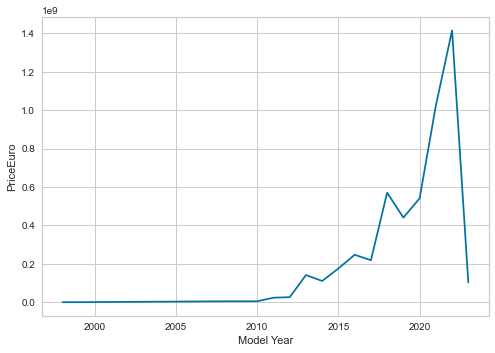

In [8]:
evs_pivot = evs.groupby(["Model Year"])["PriceEuro"].sum().reset_index()
sns.lineplot(x = "Model Year", y = "PriceEuro",  data = evs_pivot)
plt.show()

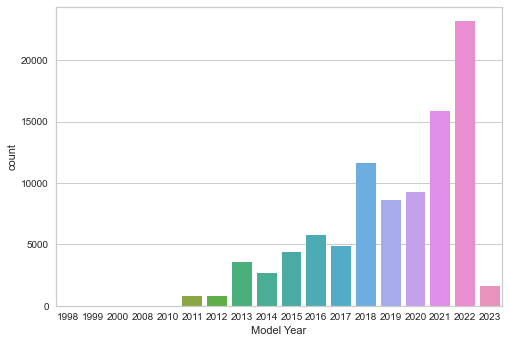

In [9]:
sns.countplot(x = 'Model Year', data = evs)
plt.show()

#### The sales are not because of more models sold as more models were sold in the latest of years
* What model is responsible for the sales in the years from 2008-2011 ? 

In [10]:
evs.loc[evs["Model Year"].isin(list(range(2008, 2011))), "Model"].value_counts()

Roadster     47
Name: Model, dtype: int64

In [11]:
evs.loc[evs["Model Year"].isin(list(range(2008, 2011))), :]

County               City State  Model Year   Make      Model  \
88544       King           Bellevue    WA        2010  TESLA  Roadster    
88545       King        Federal Way    WA        2010  TESLA  Roadster    
88546      Clark      Brush Prairie    WA        2010  TESLA  Roadster    
88547       King           Kirkland    WA        2010  TESLA  Roadster    
88549       King           Kirkland    WA        2008  TESLA  Roadster    
88551       King             Burien    WA        2008  TESLA  Roadster    
88552     Pierce             Tacoma    WA        2010  TESLA  Roadster    
88553       King           Kirkland    WA        2010  TESLA  Roadster    
88555       King           Issaquah    WA        2008  TESLA  Roadster    
88556       King         North Bend    WA        2010  TESLA  Roadster    
88557       King           Bellevue    WA        2010  TESLA  Roadster    
88558       King             Burien    WA        2010  TESLA  Roadster    
88560       King            Seattle    WA        2010  TESLA  Roadster    
88561       King           Bellevue    WA        2008  TESLA  Roadster    
88562     Kitsap  Bainbridge Island    WA        2010  TESLA  Roadster    
88563     Pierce         Steilacoom    WA        2010  TESLA  Roadster    
88564       King            Redmond    WA        2010  TESLA  Roadster    
88565    Whatcom           Ferndale    WA        2008  TESLA  Roadster    
88566     Island           Freeland    WA        2010  TESLA  Roadster    
88568       King            Seattle    WA        2010  TESLA  Roadster    
88569   San Juan      Friday Harbor    WA        2008  TESLA  Roadster    
88570       King            Seattle    WA        2008  TESLA  Roadster    
88571       King            Redmond    WA        2008  TESLA  Roadster    
88572       King            Seattle    WA        2008  TESLA  Roadster    
88573      Grant             Quincy    WA        2008  TESLA  Roadster    
88574     Pierce         Steilacoom    WA        2008  TESLA  Roadster    
88575  Snohomish            Edmonds    WA        2010  TESLA  Roadster    
88576       King           Issaquah    WA        2008  TESLA  Roadster    
88577    Spokane            Spokane    WA        2008  TESLA  Roadster    
88578       King            Seattle    WA        2008  TESLA  Roadster    
88579       King            Seattle    WA        2008  TESLA  Roadster    
88580    Spokane        Newman Lake    WA        2010  TESLA  Roadster    
88581  Snohomish           Mukilteo    WA        2010  TESLA  Roadster    
88582     Pierce         Gig Harbor    WA        2008  TESLA  Roadster    
88583       King            Seattle    WA        2008  TESLA  Roadster    
88584     Kitsap           Kingston    WA        2008  TESLA  Roadster    
88585       King            Seattle    WA        2008  TESLA  Roadster    
88586       King            Seattle    WA        2010  TESLA  Roadster    
88587       King            Redmond    WA        2008  TESLA  Roadster    
88588       King           Issaquah    WA        2010  TESLA  Roadster    
88589       King            Seattle    WA        2008  TESLA  Roadster    
88590       King           Bellevue    WA        2010  TESLA  Roadster    
88591       King            Seattle    WA        2010  TESLA  Roadster    
88592       King            Seattle    WA        2008  TESLA  Roadster    
88593       King            Seattle    WA        2010  TESLA  Roadster    
88596      Clark      Brush Prairie    WA        2010  TESLA  Roadster    
88597     Kitsap       Port Orchard    WA        2008  TESLA  Roadster    

                Electric Vehicle Type  \
88544  Battery Electric Vehicle (BEV)   
88545  Battery Electric Vehicle (BEV)   
88546  Battery Electric Vehicle (BEV)   
88547  Battery Electric Vehicle (BEV)   
88549  Battery Electric Vehicle (BEV)   
88551  Battery Electric Vehicle (BEV)   
88552  Battery Electric Vehicle (BEV)   
88553  Battery Electric Vehicle (BEV)   
88555  Battery Electric Vehicle (BEV)   

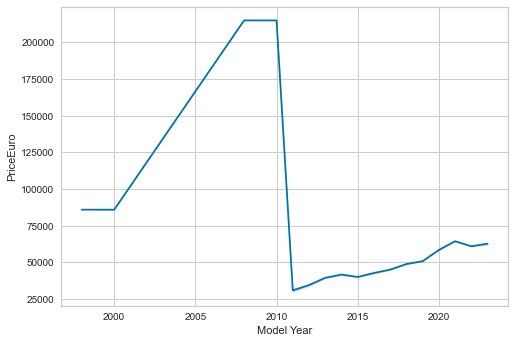

In [12]:
sns.lineplot(x = "Model Year", y = "PriceEuro",  data = evs)
plt.show()

* Only one model called the TESLA Roadster was sold for 215000 Euros in the years from 2008-2010
* If the roadster model with the 47 models is ignored we should notice a downward trend from 2000-2010 and spiking trend from the years 2010 to 2020 because of the increase in sales of electric cars.
* The trend shows the prices have dropped drastically 

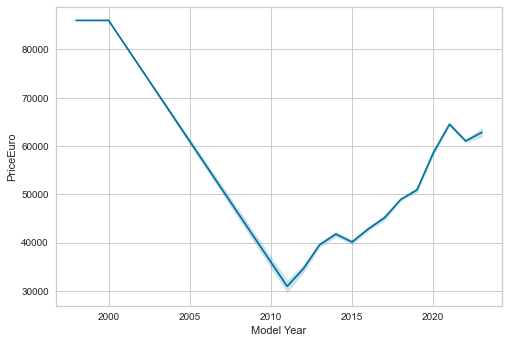

In [13]:
sns.lineplot(x = "Model Year", y = "PriceEuro",  data = evs.drop(evs.loc[evs["Model Year"].isin(list(range(2008, 2011))), :].index)) 
plt.show()

* As you can see the sales have risen and the prices have gone down indicating that in the future even common people will be able to afford an electric car.

* Since our data is from the US due to unavailability of our data from India, we cannot do geographic segmentation. But if we can profile the demographics of individual US states our segmentation will help with the analysis. So we will be keeping the State parameter and eliminate the rest of the Geographic segments

* It also wouldn't make sense to segment based on time. We can simply assume that the EV prices are going to reduce over time and operate on that assumption. Based on the provided data we should really try to identify segments that affect the price in euro of the individual vehicles and the reason for their sales. 

In [14]:
vehicles = evs.drop(columns=["County", "City", "Model Year"])

In [15]:
display(vehicles)

State     Make                  Model  \
0        WA   NISSAN                  Leaf    
1        WA   NISSAN                  Leaf    
2        WA   NISSAN                  Leaf    
3        WA   NISSAN                  Leaf    
4        WA   NISSAN                  Leaf    
...     ...      ...                    ...   
93037    WA    HONDA  Cybertruck Dual Motor   
93038    WA    HONDA  Cybertruck Dual Motor   
93039    WA  PORSCHE            Enyaq iV 80   
93040    WA      BMW       500e Convertible   
93041    WA      BMW       500e Convertible   

                        Electric Vehicle Type  \
0              Battery Electric Vehicle (BEV)   
1              Battery Electric Vehicle (BEV)   
2              Battery Electric Vehicle (BEV)   
3              Battery Electric Vehicle (BEV)   
4              Battery Electric Vehicle (BEV)   
...                                       ...   
93037  Plug-in Hybrid Electric Vehicle (PHEV)   
93038  Plug-in Hybrid Electric Vehicle (PHEV)   
93039  Plug-in Hybrid Electric Vehicle (PHEV)   
93040  Plug-in Hybrid Electric Vehicle (PHEV)   
93041  Plug-in Hybrid Electric Vehicle (PHEV)   

      Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0               Clean Alternative Fuel Vehicle Eligible              73   
1               Clean Alternative Fuel Vehicle Eligible              75   
2               Clean Alternative Fuel Vehicle Eligible              75   
3               Clean Alternative Fuel Vehicle Eligible              84   
4               Clean Alternative Fuel Vehicle Eligible             150   
...                                                 ...             ...   
93037             Not eligible due to low battery range              13   
93038             Not eligible due to low battery range              13   
93039             Not eligible due to low battery range              12   
93040             Not eligible due to low battery range              16   
93041             Not eligible due to low battery range              16   

       Base MSRP  Legislative District  \
0              0                  15.0   
1              0                  38.0   
2              0                  21.0   
3              0                  10.0   
4              0                  38.0   
...          ...                   ...   
93037          0                   2.0   
93038          0                  39.0   
93039     845000                  48.0   
93040          0                   5.0   
93041          0                  44.0   

                                    Electric Utility    Brand  ...  Range_Km  \
0                                         PACIFICORP  Nissan   ...       220   
1                             PUGET SOUND ENERGY INC  Nissan   ...       220   
2                             PUGET SOUND ENERGY INC  Nissan   ...       220   
3                             PUGET SOUND ENERGY INC  Nissan   ...       220   
4                             PUGET SOUND ENERGY INC  Nissan   ...       220   
...                                              ...      ...  ...       ...   
93037                         PUGET SOUND ENERGY INC   Tesla   ...       460   
93038                         PUGET SOUND ENERGY INC   Tesla   ...       460   
93039  PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)   Skoda   ...       420   
93040  PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)    Fiat   ...       250   
93041                         PUGET SOUND ENERGY INC    Fiat   ...       250   

       Efficiency_WhKm  FastCharge_KmH  RapidCharge PowerTrain  \
0                  164             230          Yes        FWD   
1                  164             230          Yes        FWD   
2                  164             230          Yes        FWD   
3                  164             230          Yes        FWD   
4                  164             230          Yes        FWD   
...                ...             ...          ...        ...   
93037              261 

In [16]:
en_vehicles = pd.get_dummies(vehicles, drop_first=True, sparse = False).dropna().drop(columns = ["PriceEuro"])

In [17]:
en_vehicles

Electric Range  Base MSRP  Legislative District  AccelSec  \
0                  73          0                  15.0       7.9   
1                  75          0                  38.0       7.9   
2                  75          0                  21.0       7.9   
3                  84          0                  10.0       7.9   
4                 150          0                  38.0       7.9   
...               ...        ...                   ...       ...   
93037              13          0                   2.0       5.0   
93038              13          0                  39.0       5.0   
93039              12     845000                  48.0       8.8   
93040              16          0                   5.0       9.0   
93041              16          0                  44.0       9.0   

       TopSpeed_KmH  Range_Km  Efficiency_WhKm  Seats  State_AR  State_AZ  \
0               144       220              164      5         0         0   
1               144       220              164      5         0         0   
2               144       220              164      5         0         0   
3               144       220              164      5         0         0   
4               144       220              164      5         0         0   
...             ...       ...              ...    ...       ...       ...   
93037           190       460              261      6         0         0   
93038           190       460              261      6         0         0   
93039           160       420              183      5         0         0   
93040           150       250              168      4         0         0   
93041           150       250              168      4         0         0   

       ...  BodyStyle_SPV  BodyStyle_SUV  BodyStyle_Sedan  Segment_B  \
0      ...              0              0                0          0   
1      ...              0              0                0          0   
2      ...              0              0                0          0   
3      ...              0              0                0          0   
4      ...              0              0                0          0   
...    ...            ...            ...              ...        ...   
93037  ...              0              0                0          0   
93038  ...              0              0                0          0   
93039  ...              0              1                0          0   
93040  ...              0              0                0          1   
93041  ...              0              0                0          1   

       Segment_C  Segment_D  Segment_E  Segment_F  Segment_N  Segment_S  
0              1          0          0          0          0          0  
1              1          0          0          0          0          0  
2              1          0          0          0          0          0  
3              1          0          0          0          0          0  
4              1          0          0          0          0          0  
...          ...        ...        ...        ...        ...        ...  
93037          0          0          0          0          1          0  
93038          0          0          0          0          1          0  
93039          1          0          0          0          0          0  
93040          0          0          0          0          0          0  
93041          0          0          0          0          0          0  

[92822 rows x 296 columns]

In [18]:
pca = PCA(n_components=296)
pca.fit(en_vehicles)
np.cumsum(pca.explained_variance_ratio_) 

array([0.99980787, 0.99991586, 0.99999466, 0.99999713, 0.99999871,
       0.99999996, 0.99999997, 0.99999997, 0.99999998, 0.99999998,
       0.99999998, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [19]:
pca = PCA(n_components=2)
pca.fit(en_vehicles)
compressed_evs = pca.transform(en_vehicles)
components = pca.components_

In [20]:
np.where(components > 0.3, 1, 0) 

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

In [21]:
compressed_evs_df = pd.DataFrame(compressed_evs, columns=["f1", "f2"])
fig = px.scatter(compressed_evs_df, x = "f1", y = "f2")
fig.show()

* Most of the variance can be compressed into simply one column. 

* Feature selection using PCAdecomposition might not be as useful as we had expected. 

* There is one outlier defying all expectations in variance of f1. 

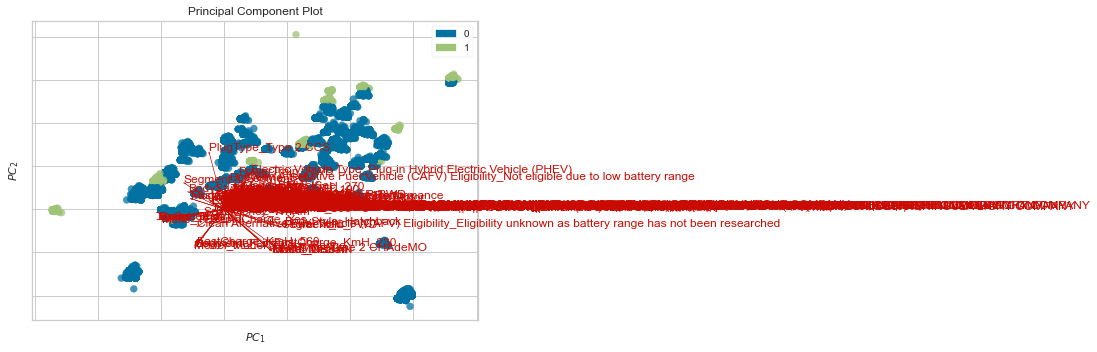

In [22]:
kmeans = KMeans(n_clusters=2)
pca = PCA(n_components=2)
kmeans.fit(en_vehicles)
trf_X = pca.fit_transform(en_vehicles)
X, y = en_vehicles, kmeans.labels_

kmeans.fit(trf_X)

visualizer = PCADecomposition(scale = True, color = None, proj_features=True)
visualizer.fit_transform(X, y)
visualizer.show()
plt.show()

* Oof.. that's not very pretty we might have to select a few features from the provided dataset 

In [23]:
def elbowMethod(data, cluster_range = (2, 13)):
    models = {}
    for i, k in tqdm(enumerate(range(cluster_range[0], cluster_range[1]))): 
        kmeans = KMeans(n_clusters=k) 
        labels = kmeans.fit_predict(data)
        inertia = kmeans.inertia_ 
        models[f"model {i+1}"] = {"inertia": inertia, "labels":labels, "model":kmeans, "clusters":k}

    return models    


        
def silouhetteMethod(data, cluster_range = (2, 13)): 
    models = {}
    for i, k in tqdm(enumerate(range(cluster_range[0], cluster_range[1]))): 

        kmeans = KMeans(n_clusters=k) 
        kmeans.fit(data)
        labels = kmeans.labels_
        score = silhouette_score(data, kmeans.labels_)
        models[f"model {i+1}"] = {"score": score, "labels":labels, "model":kmeans, "clusters":k}

    return models 

models_elbow = elbowMethod(en_vehicles)


11it [00:30,  2.78s/it]


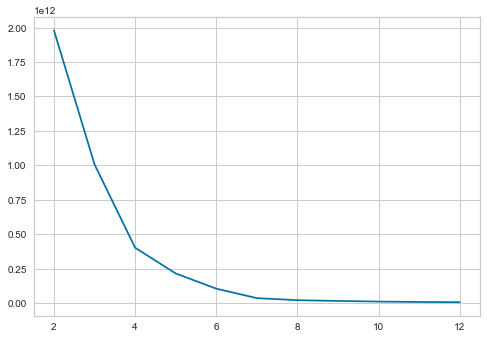

In [114]:
momentum = []
cluster = []
for model_number, value in models_elbow.items():
    momentum.append(value["inertia"])
    cluster.append(value["clusters"])

sns.lineplot(x = cluster, y = momentum)
plt.show()

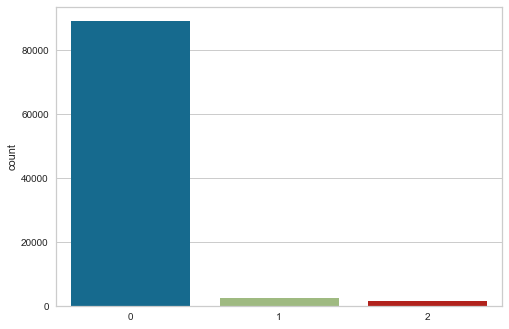

In [34]:
sns.countplot(pd.Series(models_elbow["model 2"]["labels"])) 
plt.show()

* cluster 1 and 2 are behaving as outliers so let's repeat the process after eliminating the two clusters. 

In [35]:
en_vehicles["cluster"] = models_elbow["model 2"]["labels"]
new_vehicles = en_vehicles.drop(en_vehicles[en_vehicles["cluster"] != 0].index)
display(new_vehicles)

Electric Range  Base MSRP  Legislative District  AccelSec  \
0                  73          0                  15.0       7.9   
1                  75          0                  38.0       7.9   
2                  75          0                  21.0       7.9   
3                  84          0                  10.0       7.9   
4                 150          0                  38.0       7.9   
...               ...        ...                   ...       ...   
93036              13          0                  40.0       5.0   
93037              13          0                   2.0       5.0   
93038              13          0                  39.0       5.0   
93040              16          0                   5.0       9.0   
93041              16          0                  44.0       9.0   

       TopSpeed_KmH  Range_Km  Efficiency_WhKm  Seats  State_AR  State_AZ  \
0               144       220              164      5         0         0   
1               144       220              164      5         0         0   
2               144       220              164      5         0         0   
3               144       220              164      5         0         0   
4               144       220              164      5         0         0   
...             ...       ...              ...    ...       ...       ...   
93036           190       460              261      6         0         0   
93037           190       460              261      6         0         0   
93038           190       460              261      6         0         0   
93040           150       250              168      4         0         0   
93041           150       250              168      4         0         0   

       ...  BodyStyle_SUV  BodyStyle_Sedan  Segment_B  Segment_C  Segment_D  \
0      ...              0                0          0          1          0   
1      ...              0                0          0          1          0   
2      ...              0                0          0          1          0   
3      ...              0                0          0          1          0   
4      ...              0                0          0          1          0   
...    ...            ...              ...        ...        ...        ...   
93036  ...              0                0          0          0          0   
93037  ...              0                0          0          0          0   
93038  ...              0                0          0          0          0   
93040  ...              0                0          1          0          0   
93041  ...              0                0          1          0          0   

       Segment_E  Segment_F  Segment_N  Segment_S  cluster  
0              0          0          0          0        0  
1              0          0          0          0        0  
2              0          0          0          0        0  
3              0          0          0          0        0  
4              0          0          0          0        0  
...          ...        ...        ...        ...      ...  
93036          0          0          1          0        0  
93037          0          0          1          0        0  
93038          0          0          1          0        0  
93040          0          0          0          0        0  
93041          0          0          0          0        0  

[89120 rows x 297 columns]

11it [00:35,  3.20s/it]


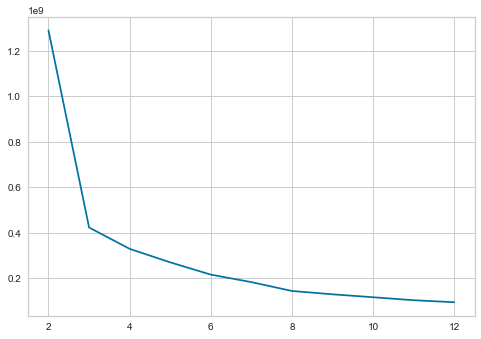

In [41]:
models2_elbow = elbowMethod(new_vehicles)
momentum = []
cluster = []
for model_number, value in models2_elbow.items():
    momentum.append(value["inertia"])
    cluster.append(value["clusters"])

sns.lineplot(x = cluster, y = momentum)
plt.show()

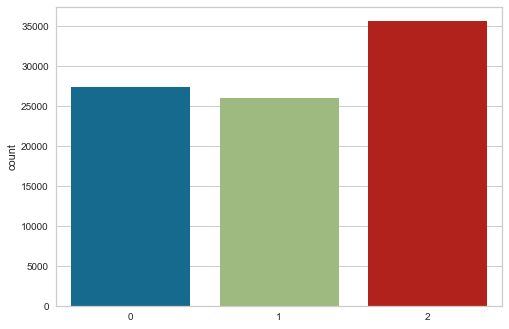

In [43]:
sns.countplot(pd.Series(models2_elbow["model 2"]["labels"])) 
plt.show()

In [45]:
pd.Series(models2_elbow["model 2"]["labels"]).value_counts()

2    35639
0    27440
1    26041
dtype: int64

In [70]:
kmeans = models2_elbow["model 2"]["model"]
new_vehicles["cluster"] = models2_elbow["model 2"]["labels"]
X, y = new_vehicles.drop(columns = ["cluster"]), new_vehicles["cluster"]
display(X)

Electric Range  Base MSRP  Legislative District  AccelSec  \
0                  73          0                  15.0       7.9   
1                  75          0                  38.0       7.9   
2                  75          0                  21.0       7.9   
3                  84          0                  10.0       7.9   
4                 150          0                  38.0       7.9   
...               ...        ...                   ...       ...   
93036              13          0                  40.0       5.0   
93037              13          0                   2.0       5.0   
93038              13          0                  39.0       5.0   
93040              16          0                   5.0       9.0   
93041              16          0                  44.0       9.0   

       TopSpeed_KmH  Range_Km  Efficiency_WhKm  Seats  State_AR  State_AZ  \
0               144       220              164      5         0         0   
1               144       220              164      5         0         0   
2               144       220              164      5         0         0   
3               144       220              164      5         0         0   
4               144       220              164      5         0         0   
...             ...       ...              ...    ...       ...       ...   
93036           190       460              261      6         0         0   
93037           190       460              261      6         0         0   
93038           190       460              261      6         0         0   
93040           150       250              168      4         0         0   
93041           150       250              168      4         0         0   

       ...  BodyStyle_SPV  BodyStyle_SUV  BodyStyle_Sedan  Segment_B  \
0      ...              0              0                0          0   
1      ...              0              0                0          0   
2      ...              0              0                0          0   
3      ...              0              0                0          0   
4      ...              0              0                0          0   
...    ...            ...            ...              ...        ...   
93036  ...              0              0                0          0   
93037  ...              0              0                0          0   
93038  ...              0              0                0          0   
93040  ...              0              0                0          1   
93041  ...              0              0                0          1   

       Segment_C  Segment_D  Segment_E  Segment_F  Segment_N  Segment_S  
0              1          0          0          0          0          0  
1              1          0          0          0          0          0  
2              1          0          0          0          0          0  
3              1          0          0          0          0          0  
4              1          0          0          0          0          0  
...          ...        ...        ...        ...        ...        ...  
93036          0          0          0          0          1          0  
93037          0          0          0          0          1          0  
93038          0          0          0          0          1          0  
93040          0          0          0          0          0          0  
93041          0          0          0          0          0          0  

[89120 rows x 296 columns]

In [106]:
k = 20
selector = SelectKBest(mutual_info_classif, k = k)
selector.fit(X, y)
relevant_cols = list(X.columns[selector.get_support()]) 
X[relevant_cols]

Electric Range  AccelSec  TopSpeed_KmH  Range_Km  Efficiency_WhKm  \
0                  73       7.9           144       220              164   
1                  75       7.9           144       220              164   
2                  75       7.9           144       220              164   
3                  84       7.9           144       220              164   
4                 150       7.9           144       220              164   
...               ...       ...           ...       ...              ...   
93036              13       5.0           190       460              261   
93037              13       5.0           190       460              261   
93038              13       5.0           190       460              261   
93040              16       9.0           150       250              168   
93041              16       9.0           150       250              168   

       Make_NISSAN  Make_TESLA  Model_Leaf   CAN  Brand_Nissan   Brand_Tesla   \
0                1           0            1    0              1             0   
1                1           0            1    0              1             0   
2                1           0            1    0              1             0   
3                1           0            1    0              1             0   
4                1           0            1    0              1             0   
...            ...         ...          ...  ...            ...           ...   
93036            0           0            0    0              0             1   
93037            0           0            0    0              0             1   
93038            0           0            0    0              0             1   
93040            0           0            0    0              0             0   
93041            0           0            0    0              0             0   

       FastCharge_KmH_230  FastCharge_KmH_560  PowerTrain_FWD  \
0                       1                   0               1   
1                       1                   0               1   
2                       1                   0               1   
3                       1                   0               1   
4                       1                   0               1   
...                   ...                 ...             ...   
93036                   0                   0               0   
93037                   0                   0               0   
93038                   0                   0               0   
93040                   0                   0               1   
93041                   0                   0               1   

       PlugType_Type 2 CHAdeMO  BodyStyle_Hatchback  BodyStyle_Sedan  \
0                            1                    1                0   
1                            1                    1                0   
2                            1                    1                0   
3                            1                    1                0   
4                            1                    1                0   
...                        ...                  ...              ...   
93036                        0                    0                0   
93037                        0                    0                0   
93038                        0                    0                0   
93040                        0                    0                0   
93041                        0                    0                0   

       Segment_C  Segment_D  Segment_F  
0              1          0          0  
1              1          0          0  
2              1          0          0  
3              1          0          0  
4              1          0          0  
...          ...        ...        ...  
93036          0          0          0  
93037          0          0          0  
93038          0          0          0  
93040          0          0          0  
93041          0        

* These are the most relevant 20 columns that we will now compress to understand the behaviour of segments on a plane

In [107]:
modified_df = X[relevant_cols]
display(modified_df.sample(20))

Electric Range  AccelSec  TopSpeed_KmH  Range_Km  Efficiency_WhKm  \
23152             322       4.6           233       450              161   
89590              13       8.3           145       170              168   
79605               0       5.1           180       370              216   
33818             215       4.6           233       450              161   
70504               0       3.8           250       515              184   
31354               0       4.6           233       450              161   
69981               0       3.8           250       515              184   
22960               0       4.6           233       450              161   
48858              19       3.4           261       435              167   
72336               0       3.8           250       515              184   
56968             153       7.3           150       235              161   
688               107       7.9           144       220              164   
37834               0       4.6           233       450              161   
20266             322       4.6           233       450              161   
60982               0       3.8           250       515              184   
7931               84       7.9           144       220              164   
45339              30      10.0           160       290              179   
2365               75       7.9           144       220              164   
54297             330       5.1           217       425              171   
87881             204       3.5           240       425              197   

       Make_NISSAN  Make_TESLA  Model_Leaf   CAN  Brand_Nissan   Brand_Tesla   \
23152            0           1            0    0              0             1   
89590            0           0            0    0              0             0   
79605            0           0            0    1              0             0   
33818            0           1            0    0              0             1   
70504            0           1            0    1              0             1   
31354            0           1            0    1              0             1   
69981            0           1            0    1              0             1   
22960            0           1            0    1              0             1   
48858            0           0            0    0              0             1   
72336            0           1            0    1              0             1   
56968            0           0            0    0              0             0   
688              1           0            1    0              1             0   
37834            0           1            0    1              0             1   
20266            0           1            0    0              0             1   
60982            0           1            0    1              0             1   
7931             1           0            1    0              1             0   
45339            0           0            0    0              0             0   
2365             1           0            1    0              1             0   
54297            0           1            0    0              0             1   
87881            0           0            0    0              0             0   

       FastCharge_KmH_230  FastCharge_KmH_560  PowerTrain_FWD  \
23152                   0                   0               0   
89590                   0                   0               0   
79605                   0                   0               0   
33818                   0                   0               0   
70504                   0                   1               0   
31354                   0                   0               0   
69981                   0                   1               0   
22960                   0                   0               0   
48858                   0                   0               0   
72336                   0                   1             

In [108]:
pca = PCA(n_components=20)
pca.fit(modified_df)
display(np.cumsum(pca.explained_variance_ratio_)) 
components = pca.components_

array([0.56114675, 0.98033186, 0.99333707, 0.99992966, 0.99996223,
       0.99997855, 0.99998647, 0.99999054, 0.99999283, 0.9999949 ,
       0.99999654, 0.99999761, 0.99999843, 0.99999917, 0.99999949,
       0.9999998 , 0.99999991, 0.99999999, 1.        , 1.        ])

In [109]:
modified_df.rename({'Clean Alternative Fuel Vehicle (CAFV) Eligibility_Eligibility unknown as battery range has not been researched':'CAN'}, axis = 1, inplace = True)

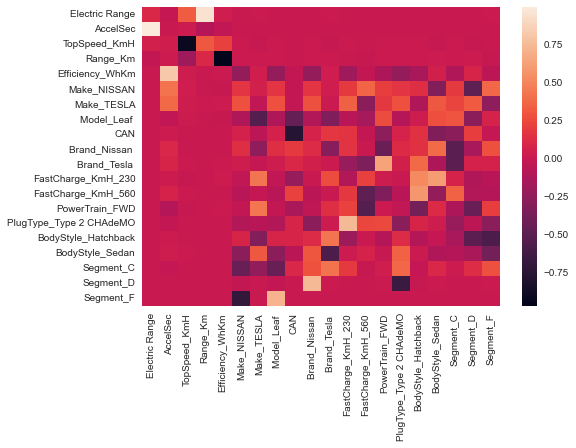

In [110]:
moddf_cols = modified_df.columns
sns.heatmap(pd.DataFrame(components, index = moddf_cols, columns=moddf_cols))  
plt.show()

In [111]:
pca = PCA(n_components=5)
pca.fit(modified_df)
display(np.cumsum(pca.explained_variance_ratio_)) 
components = pca.components_

array([0.56114675, 0.98033186, 0.99333707, 0.99992966, 0.99996223])

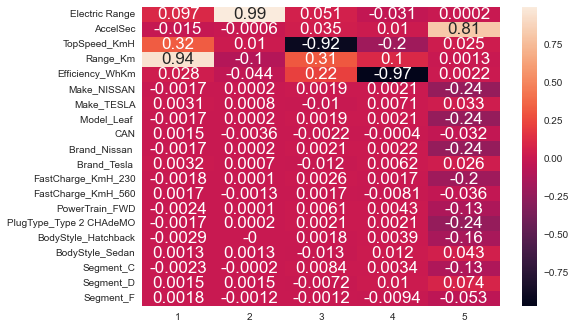

In [114]:
moddf_cols = modified_df.columns
sns.heatmap(pd.DataFrame(components.T.round(4), index = moddf_cols, columns=list(range(1, 6))), annot = True)  
plt.show()

* To be noted is that the first 4 components explain majority of the variance

* Amongst those components the majority of the variance is contributed by Range_Km, TotSpeed_KmH, Efficiency, AccelSec, PlugType_Type2 CCS 

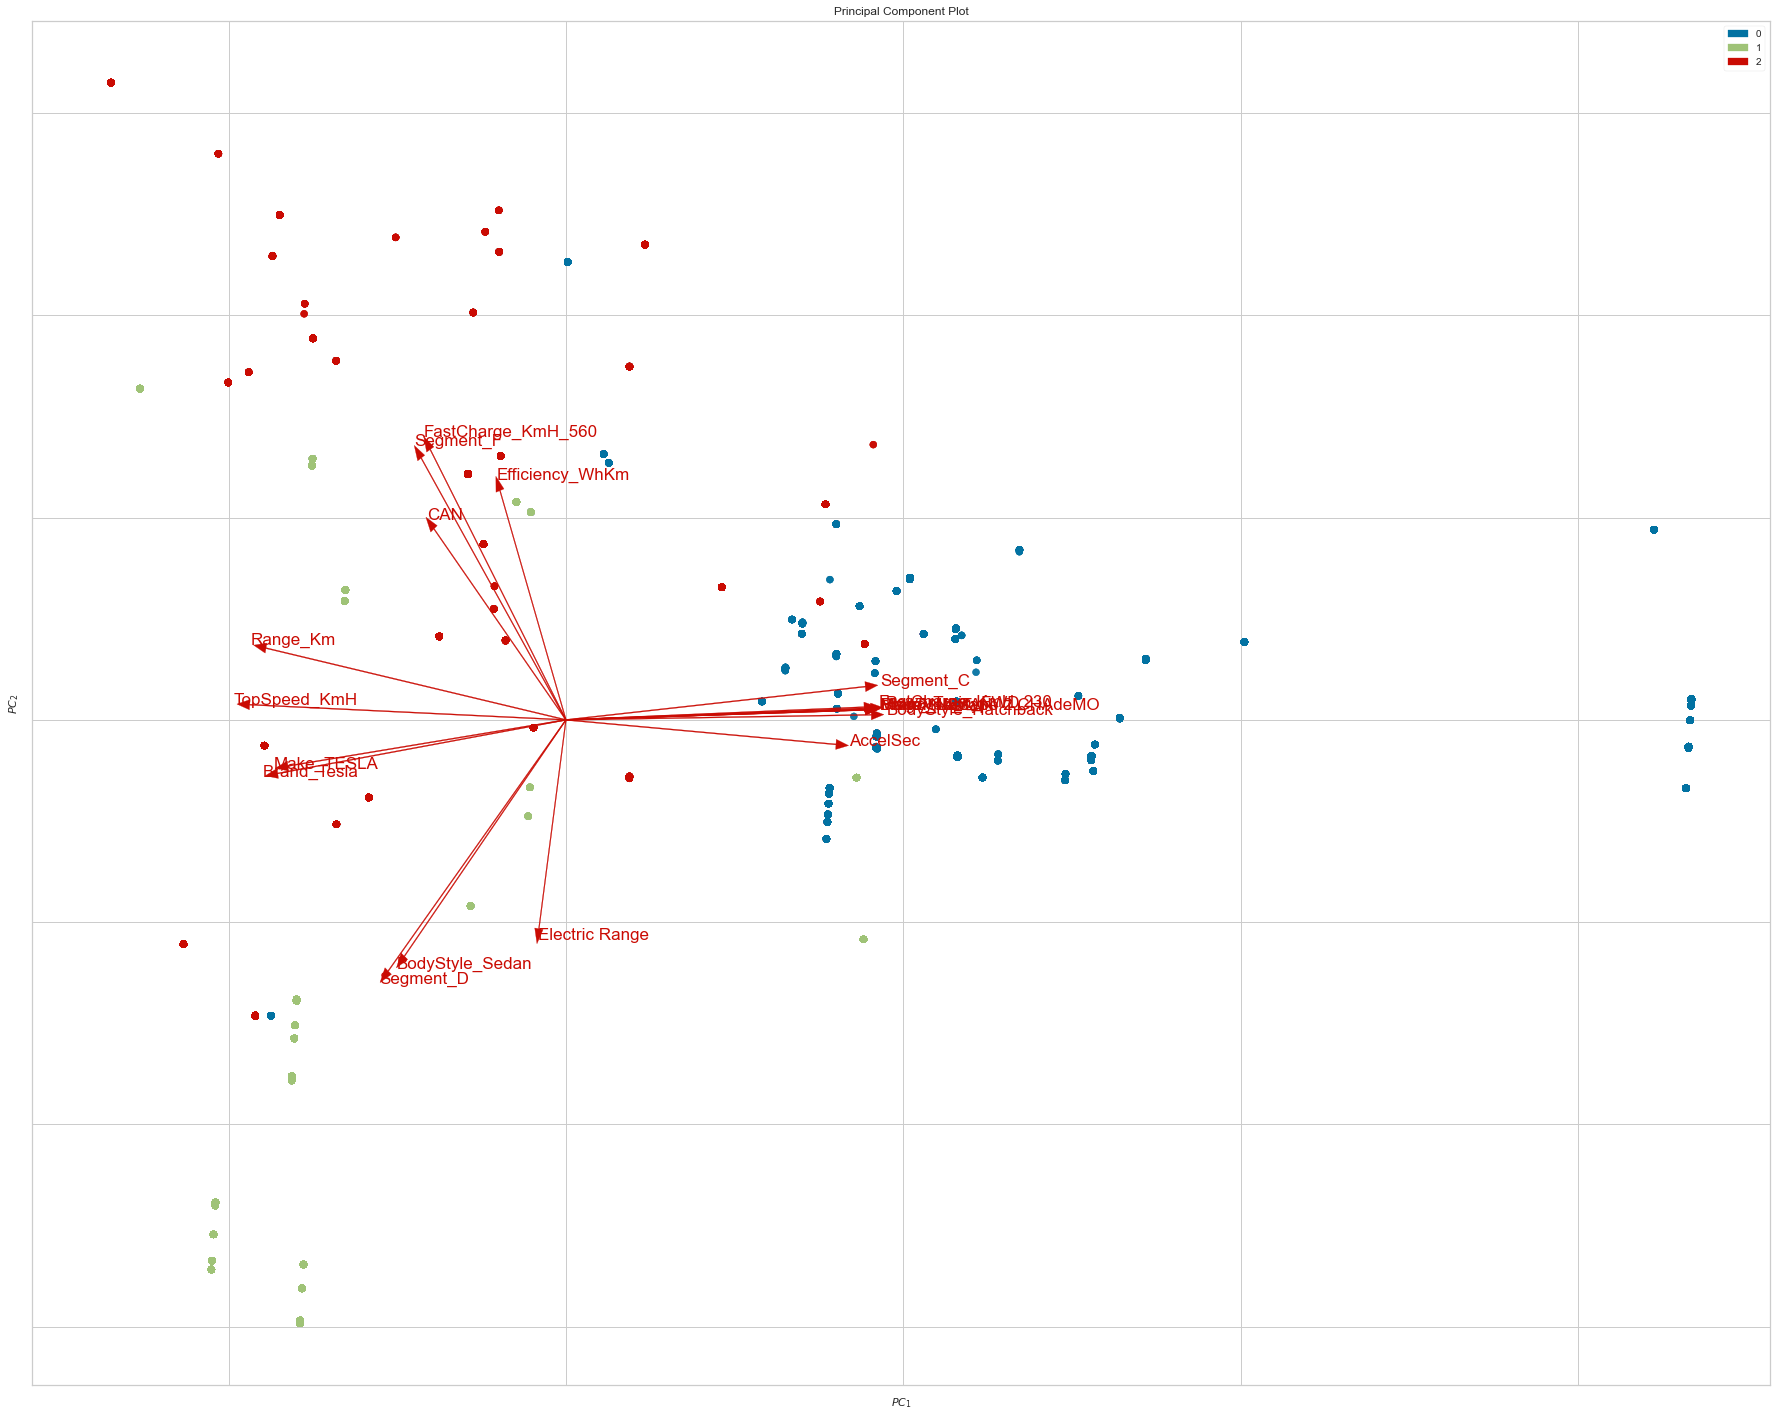

In [115]:
X = modified_df
plt.rcParams.update({'font.size': 17})
fig = plt.figure(figsize = (25, 20))
pca_decomp = PCADecomposition(scale = True, color = None, proj_features=True)
pca_decomp.fit_transform(X, y)
pca_decomp.show()
plt.show()

* You can notice that certain parameters point in certain cluster directions. 

* This information is useful because this means that different columns have different weightage on determining the clusters. 

* Now its time we analyze our clusters and identify the defining factors.

In [120]:
modified_df["segments"] = y 
modified_df.columns

Index(['Electric Range', 'AccelSec', 'TopSpeed_KmH', 'Range_Km',
       'Efficiency_WhKm', 'Make_NISSAN', 'Make_TESLA', 'Model_Leaf ', 'CAN',
       'Brand_Nissan ', 'Brand_Tesla ', 'FastCharge_KmH_230',
       'FastCharge_KmH_560', 'PowerTrain_FWD', 'PlugType_Type 2 CHAdeMO',
       'BodyStyle_Hatchback', 'BodyStyle_Sedan', 'Segment_C', 'Segment_D',
       'Segment_F', 'segments'],
      dtype='object')

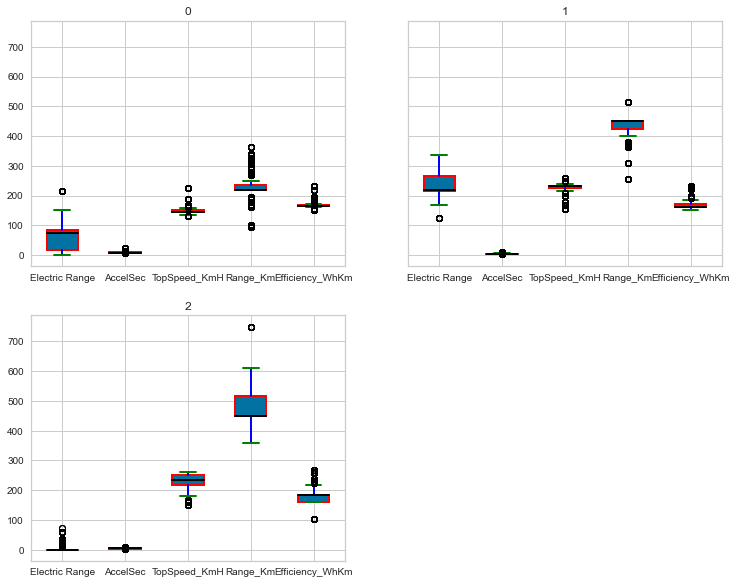

In [123]:
import matplotlib.pyplot as plt

numericals = ['Electric Range', 'AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm']

fig, ax = plt.subplots(figsize=(12, 10))

modified_df.groupby(["segments"])[numericals].boxplot(ax=ax, patch_artist=True,
                                                      boxprops=dict(linewidth=2, color='red'),
                                                      whiskerprops=dict(linewidth=2, color='blue'),
                                                      capprops=dict(linewidth=2, color='green'),
                                                      medianprops=dict(linewidth=2, color='black'),
                                                      meanprops=dict(marker='o', markerfacecolor='red', markersize=10, markeredgecolor='black'))

plt.title("Boxplot of Numerical Features by Segments")
plt.xlabel("Segments")
plt.ylabel("Value")
plt.show()


* The distribution of the numerical values seems almost equivalent in all the columns except for Electric ranges. 

* Electric range from segment two has the lowest values, segment the second most lowest and from segment 1 the highest. 


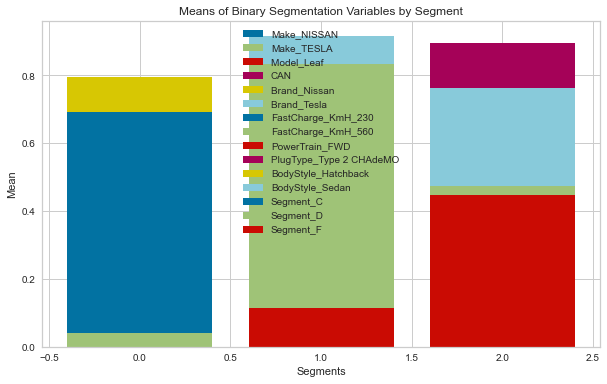

In [144]:
grouped = modified_df.groupby("segments")[['Make_NISSAN', 'Make_TESLA', 'Model_Leaf ', 'CAN',
       'Brand_Nissan ', 'Brand_Tesla ', 'FastCharge_KmH_230',
       'FastCharge_KmH_560', 'PowerTrain_FWD', 'PlugType_Type 2 CHAdeMO',
       'BodyStyle_Hatchback', 'BodyStyle_Sedan', 'Segment_C', 'Segment_D',
       'Segment_F']].mean()

fig, ax = plt.subplots(figsize=(10, 6))
for col in grouped.columns:
    ax.bar(grouped.index, grouped[col], label=col)

ax.set_title("Means of Binary Segmentation Variables by Segment")
ax.set_xlabel("Segments")
ax.set_ylabel("Mean")

ax.legend()
plt.show()

* Segment 0 consists of mostly nissan users of Segment_D column 

* Segment 1 consists of Fast_Charge_KmH_560 showing that people prefer fast cars in segment 1. It also consists of Segment_F column. 

* Segment 2 can be mostly classified as customers preferring Segment_F, and CAN, prefer sedan bodystyled tesla. 

* You can also always train a descision tree to identify segments. 

In [169]:
X, y = modified_df.drop(columns =["segments"]), modified_df["segments"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)
predictions = tree.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9665
           1       1.00      1.00      1.00      9083
           2       1.00      1.00      1.00     12444

    accuracy                           1.00     31192
   macro avg       1.00      1.00      1.00     31192
weighted avg       1.00      1.00      1.00     31192



In [170]:
confusion_matrix(y_test, predictions)

array([[ 9647,     0,    18],
       [    0,  9066,    17],
       [    0,     0, 12444]], dtype=int64)

In [160]:
X.columns

Index(['Electric Range', 'AccelSec', 'TopSpeed_KmH', 'Range_Km',
       'Efficiency_WhKm', 'Make_NISSAN', 'Make_TESLA', 'Model_Leaf ', 'CAN',
       'Brand_Nissan ', 'Brand_Tesla ', 'FastCharge_KmH_230',
       'FastCharge_KmH_560', 'PowerTrain_FWD', 'PlugType_Type 2 CHAdeMO',
       'BodyStyle_Hatchback', 'BodyStyle_Sedan', 'Segment_C', 'Segment_D',
       'Segment_F'],
      dtype='object')

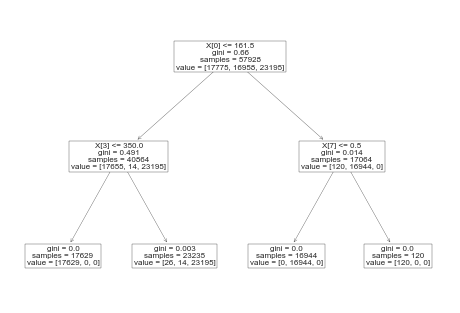

In [173]:
plot_tree(tree)
plt.show()